# Introducción

Duración estimada de la ejecución: 45 min

Cuando una sociedad se expone a una epidemía infecto contagiosa, además de las medidas oficiales para controlar su dispersión esta

In [43]:
from Simulacion2 import Simulacion
from Simulacion3 import SimulacionAgrupada
import math
import matplotlib.pyplot as plt
import numpy as np
import textwrap

In [14]:
def PlotSimulacion(
        ax1,
        ax2,
        titulo : str,
        historial_infectados : list[int],
        historial_satisfaccion : list[float],
        historial_asistencias : list[int],
        simulacion : Simulacion,
):
    ax1.plot(historial_infectados, label='Infectados')
    ax1.plot(historial_satisfaccion, label='Satisfacción')
    asistencias_posibles = len(simulacion.asistencias_posibles())
    ax1.plot([x/asistencias_posibles * simulacion.n for x in historial_asistencias], label='Asistencias')
    ax1.legend()

    m_infectados = max(historial_infectados)
    ax2.plot([x/m_infectados for x in historial_infectados], label = "Infectados reescalados (1 = maximo de infectados)")

    ax1.set_title(titulo)
    ax2.set_title(titulo)
    
    ax2.legend()

    ax1.set_xlabel("Tiempo")
    ax2.set_xlabel("Tiempo")

# Primer paso: Escenario sin oscilaciones

Hay que ajustar el tamaño de la población para llegar a un escenario donde el modelo se estabilice a lo esperable analiticamente

Mayor ruido, se diferencian más del modelo continuo

Parametros fijos

Parámetros:
*  n (int): Número de personas.
*  m (int): Número de actividades / puntos de reunión.
*  til_base (int): Tiempo base que dura el período de enfermedad en latencia. Luego de este tiempo, en cada día el individuo tiene una probabilidad de 0.5 de pasar al estado infectado.
*  tic_base (int): Tiempo base que dura el periodo de enfermedad contagiosa. Luego de este tiempo, en cada día el individuo tiene una probabilidad de 0.5 de recuperarse.
* memoria (float): Coeficiente que se utiliza para actualizar el riesgo percibido para realizar una determinada actividad.
*  max_tolerancia_riesgo (float): Máximo valor que puede tomar la tolerancia al riesgo de un individuo.
*  umbral (float): Umbral de corte de satisfacción para inicializar el grafo.
*  beta (float): Riesgo de contagio. Una persona expuesta a un lugar con A expuestos y B asistentes sigue sana con probabilidad exp(-A/(beta*B)).
*  min_asistencias_para_cerrar (int): Número mínimo de asistencias diarias para mantener una entidad abierta.
*  max_infecciones_para_evitar (int): Número máximo de infecciones que puede tener un individuo en una entidad antes de evitarla.
* politicas_publicas (bool): Indica si se implementan políticas públicas en la simulación.
*  inicial_exposeds : Cantidad de invididuos expuestos al inicio de la simulación.
        

In [2]:
M = 20   # Número de entidades
tiempo = 1000
til_base = 5
tic_base = 5
memoria = 0.5
umbral = 4
contagiosidad = 0.1
max_tolerancia_riesgo = 1e99 # anular el factor del miedo
expuestos_iniciales = 5

Parametro a modificar para llegar a la situación estable

$N$ : Cantidad de personas

In [11]:
def Generar_Escenario_N(N) -> tuple[str, list[int], list[int], list[int], Simulacion]:
    np.random.seed(123456)
    simulacion = Simulacion(N, M, til_base, tic_base, memoria, max_tolerancia_riesgo, umbral, fun_contagio = lambda expuestos, asistencias: 1-math.exp(-contagiosidad * expuestos/(asistencias)), initial_exposeds = expuestos_iniciales)
    historial_infectados, historial_satisfaccion, historial_asistencias = simulacion.ejecutar_simulacion(tiempo)
    titulo = f"Simulación con N = {N}"
    return titulo, historial_infectados, historial_satisfaccion, historial_asistencias, simulacion

In [18]:
Ns = [100, 200, 500, 1000, 2000, 10000] #, 1000, 2000, 10000]
np.random.seed(123456)
resultados = [Generar_Escenario_N(N) for N in Ns]

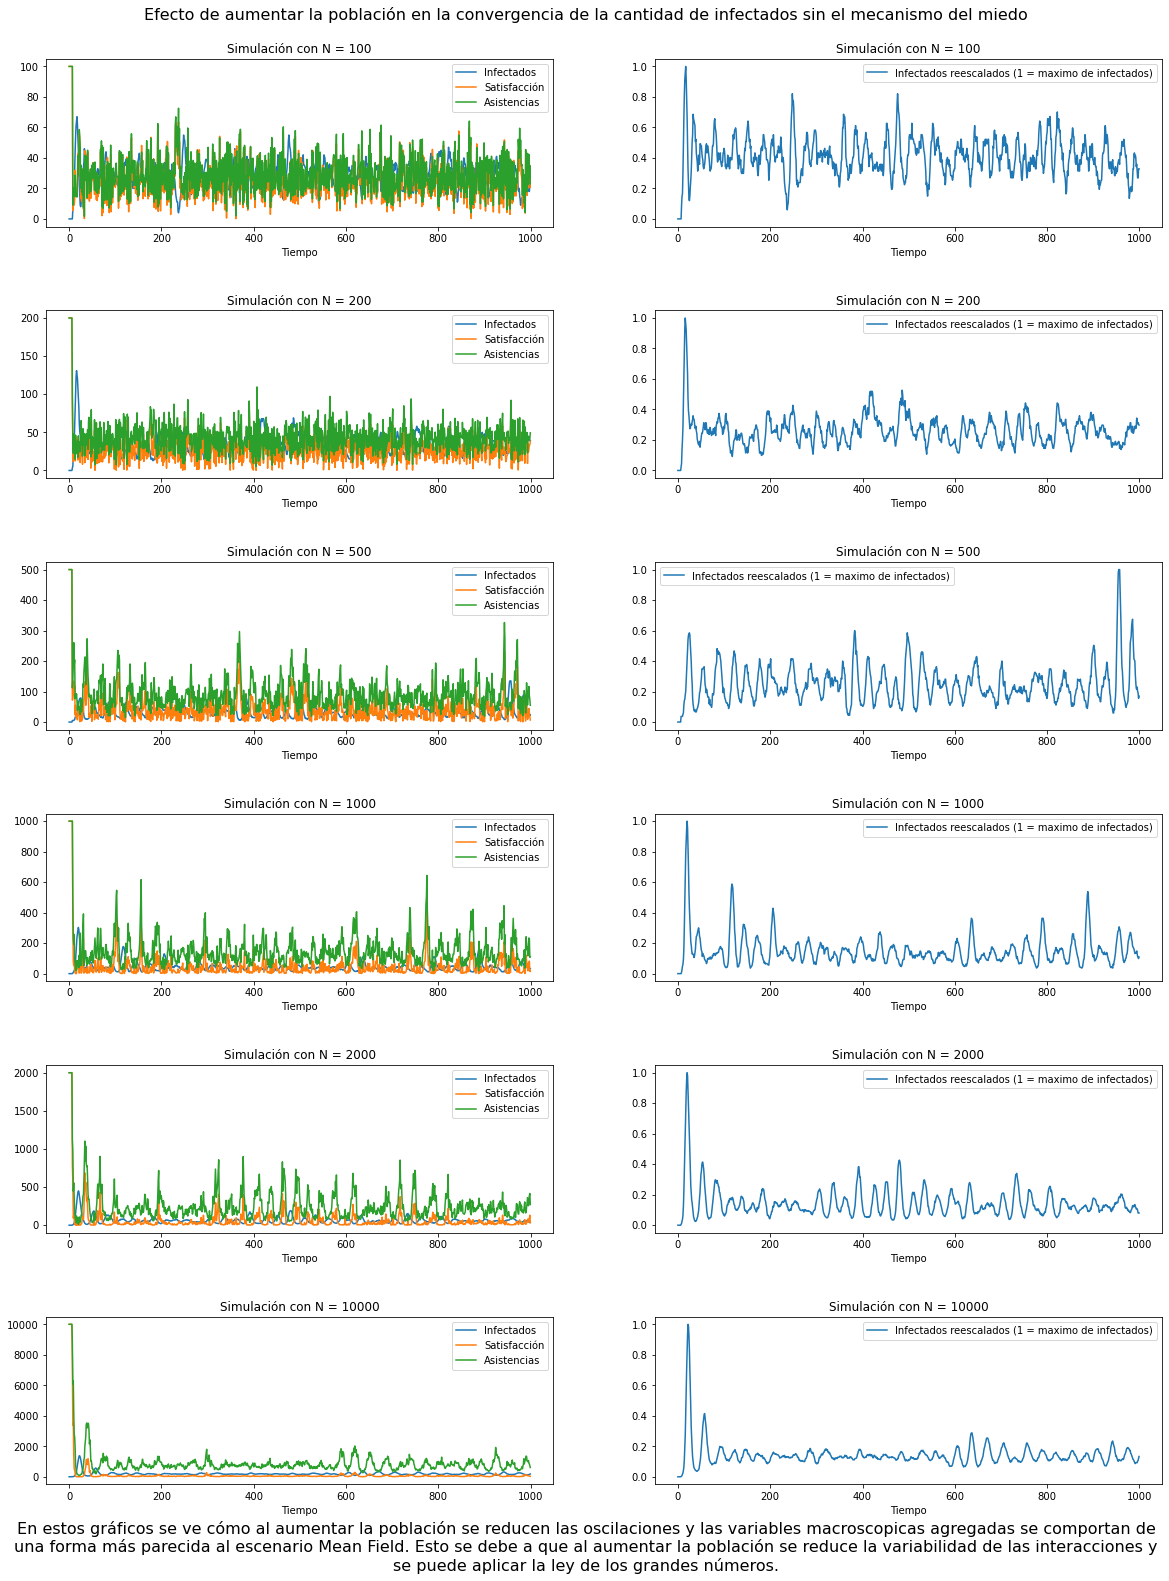

In [60]:
fig, ax = plt.subplots(nrows=len(Ns), ncols=2, figsize=(20, 4 * len(Ns)), gridspec_kw={'hspace': 0.5})
descripcion = 'En estos gráficos se ve cómo al aumentar la población se reducen las oscilaciones y las variables macroscopicas agregadas se comportan de una forma más parecida al escenario Mean Field. Esto se debe a que al aumentar la población se reduce la variabilidad de las interacciones y se puede aplicar la ley de los grandes números.'
descripcion = textwrap.fill(descripcion, width=140)
fig.text(0.5, 0.075,descripcion , ha='center', fontsize=16,)
fig.suptitle('Efecto de aumentar la población en la convergencia de la cantidad de infectados sin el mecanismo del miedo', fontsize=16)
fig.subplots_adjust(top=0.95)  # Adjust the top spacing
for i, resultado in enumerate(resultados):
    PlotSimulacion(ax[i, 0], ax[i, 1], *resultado)
plt.show()


Vemos que al aumentar la población tiende al modelo ideal SEIS (para los parametros adecuados)

# Incorporamos el miedo

Parametros fijos

In [5]:
N = 1000
M = 20   # Número de entidades
tiempo = 1000
til_base = 5
tic_base = 5
memoria = 0.5
umbral = 4
contagiosidad = 0.1
expuestos_iniciales = 5

Parametro de interes

$max\_toleracia\_riesgo$ : Máxima tolerancia de un individuo al riesgo

Función que corre un escenario

In [20]:
def Probar_Escenario_Riesgo(max_tolerancia_riesgo):
    simulacion = Simulacion(N, M, til_base, tic_base, memoria, max_tolerancia_riesgo, umbral, fun_contagio = lambda expuestos, asistencias: 1-math.exp(-contagiosidad * expuestos/(asistencias)))
    historial_infectados, historial_satisfaccion, historial_asistencias = simulacion.ejecutar_simulacion(tiempo)
    if max_tolerancia_riesgo > 1e90:
        titulo = f"Simulación sin mecanismo del miedo"
    else:
        titulo = f"Simulación con max_tolerancia_riesgo = {max_tolerancia_riesgo}"
    return titulo, historial_infectados, historial_satisfaccion, historial_asistencias, simulacion

In [21]:
max_tolerancia_riesgos = [1e99, 1, 0.01, 0.001, 0.0005, 0.000375, 0.00025, 0.0001]
np.random.seed(654321)
resultados_riesgo = [Probar_Escenario_Riesgo(max_tolerancia_riesgo) for max_tolerancia_riesgo in max_tolerancia_riesgos]

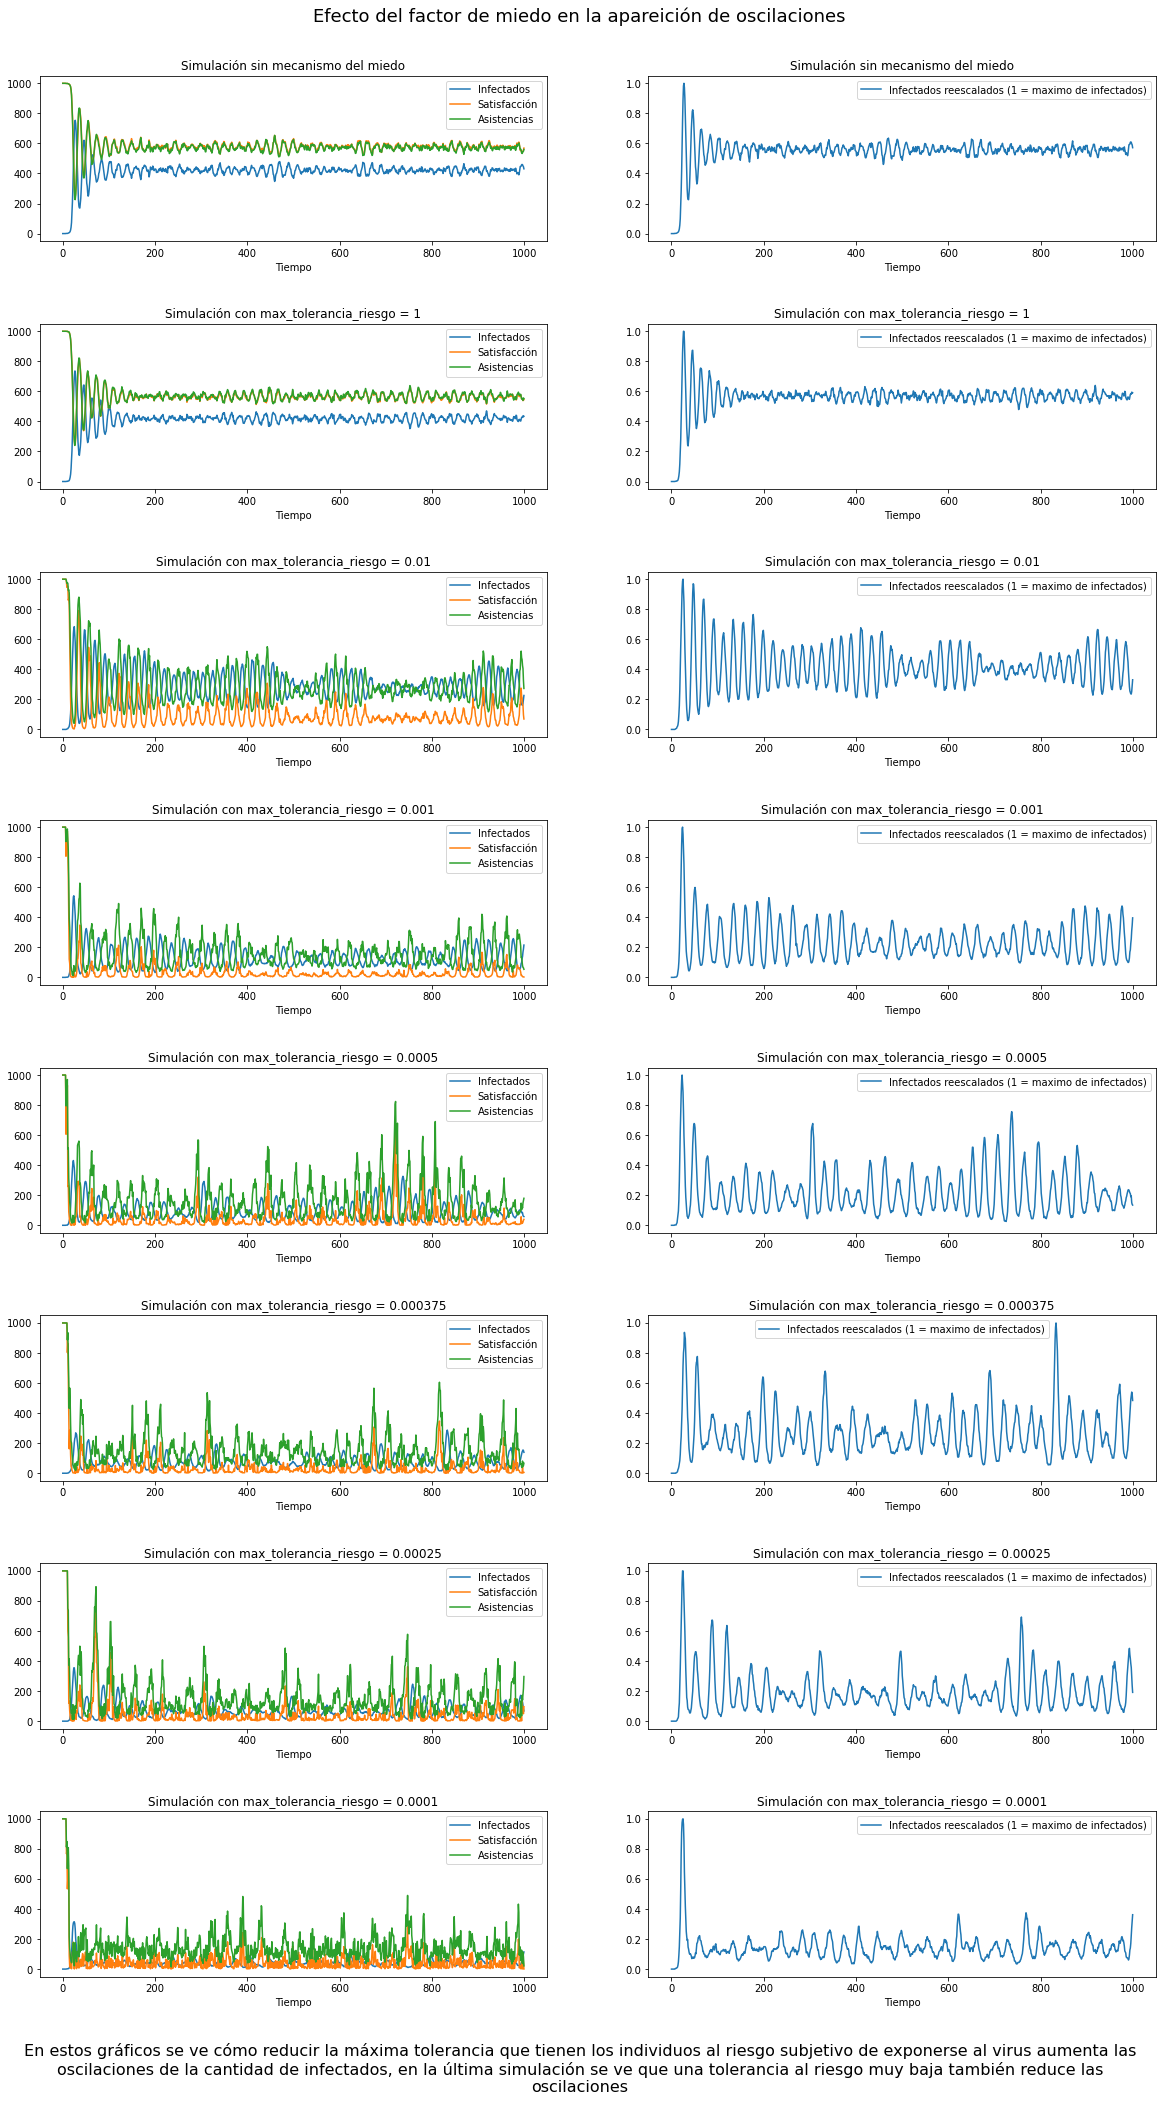

In [70]:
fig, ax = plt.subplots(nrows=len(max_tolerancia_riesgos), ncols=2, figsize=(20, 4 * len(max_tolerancia_riesgos)), gridspec_kw={'hspace': 0.5})
descripcion = 'En estos gráficos se ve cómo reducir la máxima tolerancia que tienen los individuos al riesgo subjetivo de exponerse al virus aumenta las oscilaciones de la cantidad de infectados, en la última simulación se ve que una tolerancia al riesgo muy baja también reduce las oscilaciones'
descripcion = textwrap.fill(descripcion, width=140)
fig.suptitle('Efecto del factor de miedo en la apareición de oscilaciones', fontsize=18)
fig.text(0.5, 0.075,descripcion , ha='center', fontsize=16,)
fig.subplots_adjust(top=0.95)  # Adjust the top spacing
for i, resultado in enumerate(resultados_riesgo):
    PlotSimulacion(ax[i, 0], ax[i, 1], *resultado)
plt.show()

# Simulación con grupos

Para considera situaciones en poblaciones muy grandes, donde la asistencia de cada individuo a cada actividad es independiente de su asístencia a las demás actividades, podemos construir un modelo donde agrupamos a las personas por el conjunto de actividades a las que asísten.

In [76]:
def PlotSimulacionAgrupada(
        ax1,
        ax2,
        titulo : str,
        simulacion : SimulacionAgrupada,
):
    ax1.plot(simulacion.infc_total, label = ("Expuestos", "Infectados"))
    ax1.legend(fontsize = 12)
    ax1.set_title(titulo, fontsize = 20)
    ax1.set_ylim(0,1)
    
    ax2.set_title(titulo, fontsize = 20)
    ax2.plot(simulacion.asistencias, label = ("Valuntad de asistir","Asistencia"))
    ax2.legend(fontsize = 12)
    ax2.set_ylim(0,1)


Parametros fijos

In [62]:
probs = [0.9, 0.7, 0.5, 0.3, 0.1, 0.1, 0.1, 0.1]
prob_inicial = 1e-6
etoi = 1/14
itos = 1/7
memoria = 0
info_global = True
alfa_miedo = 1
beta_miedo = 1
beta_contagio = 1
n_dias = 500


Funciones parametrizadas

Función de miedo de cada día: 

$ e^{-{casos\_nuevos}^{\alpha_{miedo}} * \beta_{miedo}} $

In [ ]:
def gen_fun_miedo(memoria : float, alfa : float, beta : float ):
    def fun_miedo(casos : list[tuple[float,float]]) -> float:
        asistencia = 1
        for (exp, inf) in casos[-14:-7]:
            asistencia = asistencia * memoria + (1-memoria)*np.exp(- (exp*etoi) ** alfa * beta)
        return asistencia
    return fun_miedo

def gen_fun_contagio(beta : float):
    def fun_contagio(sanos : float, expuestos : float, asistencia : float) -> float:
        return asistencia * np.exp(-expuestos/(beta * (1+expuestos+sanos)))
    return fun_contagio  

Explicación de la salida:
* Expuestos: Proporción de la población que está expuesta a la infección
* Infectados: Proporción de la población que está infectada (y lo sabe)
* Voluntad de asistir: Proporción de la población sana que asiste a sus activiades.
* Asistencia: Proporción de la población total que asiste a sus actividades (es igual a Volutad de asistir * (1-Infectados))

## Escenarios $\alpha_{miedo} = 1$

In [68]:
def Generar_Escenario_Beta_Miedo(beta_miedo):
    simulacion = SimulacionAgrupada(probs, etoi, itos, prob_inicial, gen_fun_miedo(memoria, alfa_miedo, beta_miedo), gen_fun_contagio(beta_contagio), info_global)
    simulacion.AvanzarHastaT(n_dias)
    titulo = f"Simulación con beta_miedo = {beta_miedo}"
    return titulo, simulacion

In [71]:
betas_miedo = [1, 10, 100, 200, 400, 800, 2000]
np.random.seed(123456)
resultados_beta_miedo = [Generar_Escenario_Beta_Miedo(beta_miedo) for beta_miedo in betas_miedo]

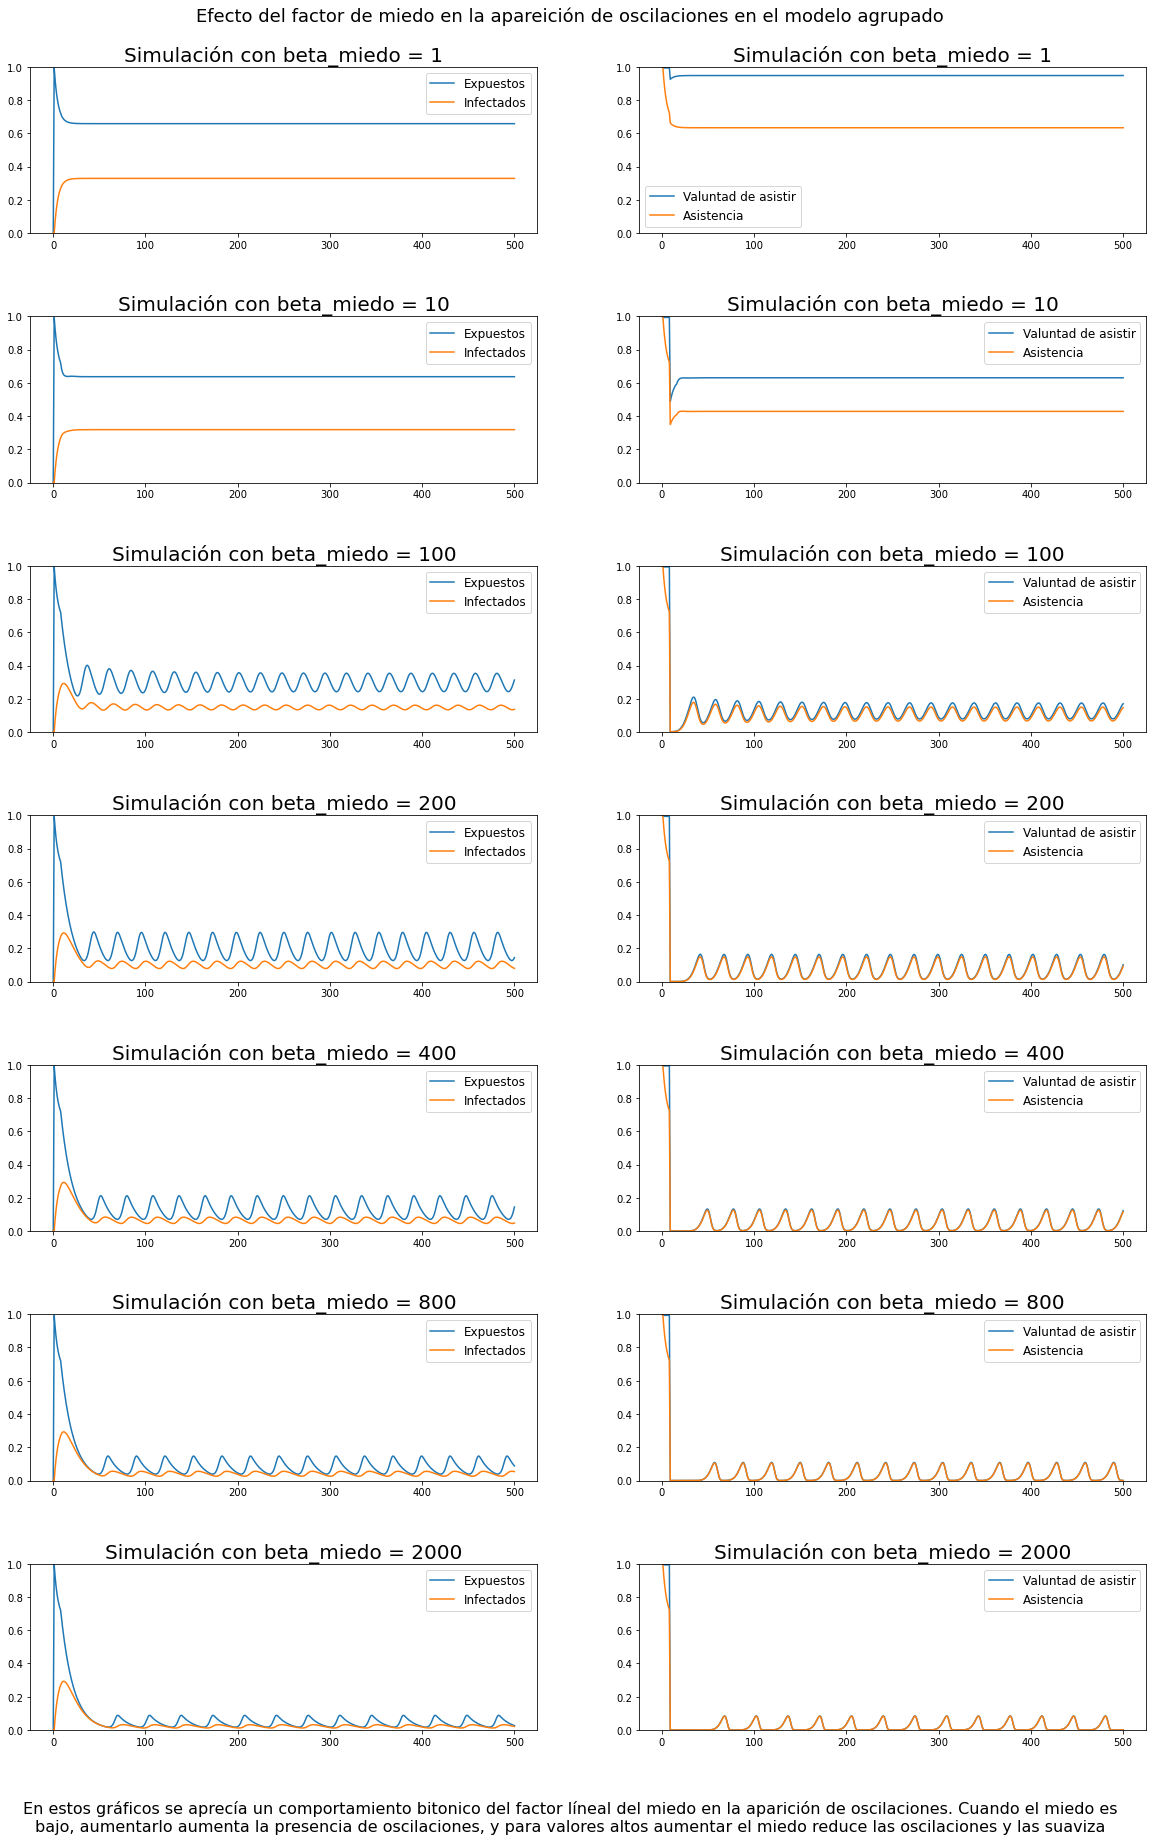

In [78]:
fig, ax = plt.subplots(nrows=len(betas_miedo), ncols=2, figsize=(20, 4 * len(betas_miedo)), gridspec_kw={'hspace': 0.5})
descripcion = "En estos gráficos se aprecía un comportamiento bitonico del factor líneal del miedo en la aparición de oscilaciones. Cuando el miedo es bajo, aumentarlo aumenta la presencia de oscilaciones, y para valores altos aumentar el miedo reduce las oscilaciones y las suaviza"
descripcion = textwrap.fill(descripcion, width=140)
fig.suptitle('Efecto del factor de miedo en la apareición de oscilaciones en el modelo agrupado', fontsize=18)
fig.text(0.5, 0.075,descripcion , ha='center', fontsize=16,)
fig.subplots_adjust(top=0.95)  # Adjust the top spacing
for i, resultado in enumerate(resultados_beta_miedo):
    PlotSimulacionAgrupada(ax[i, 0], ax[i, 1], *resultado)
plt.show()